In [1]:
import tensorflow as tf

# import os
import math
import numpy as np

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from ipynb.fs.full.dataset import *
from ipynb.fs.full.moduel import *

2022-10-19 11:42:15.367025: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
test_dir = "../dataset/test"
test_img_paths = test_imgs(test_dir)
model_weight_dir = "../model_weights/ckpt"
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()
model.load_weights(model_weight_dir)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1664        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                           

__________________________________________________________________________________________________


2022-10-19 11:42:16.576088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 11:42:16.579711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 11:42:16.579799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 11:42:16.580050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [3]:
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 3, location: upper-left
    axins = zoomed_inset_axes(ax, 4, loc=3)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 75, 160, 165, 180
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="blue")
#     plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

/tmp/ipykernel_181732/890647624.py:35: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  PIL.Image.BICUBIC,
2022-10-19 11:42:19.532843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step
PSNR of low resolution image and high resolution image is 24.4406
PSNR of predict and high resolution is 26.5427
PSNR improvement between low resolution and prediction 2.1021


/tmp/ipykernel_181732/890647624.py:56: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
/tmp/ipykernel_181732/890647624.py:57: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)


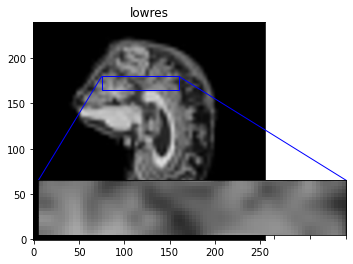

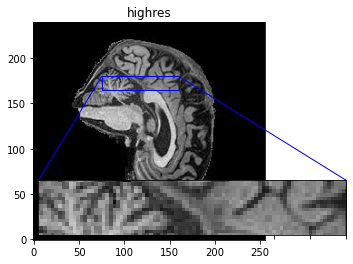

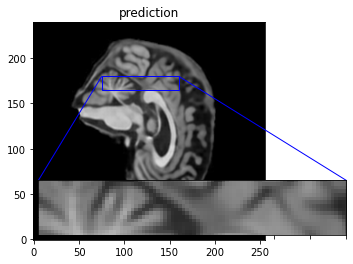

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.4841
PSNR of predict and high resolution is 27.9286
PSNR improvement between low resolution and prediction 2.4445


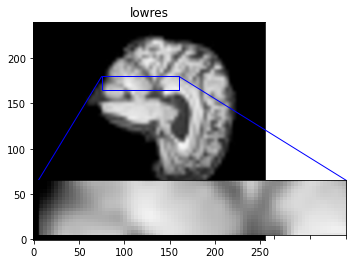

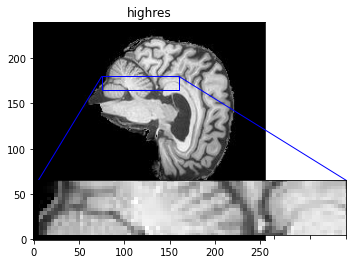

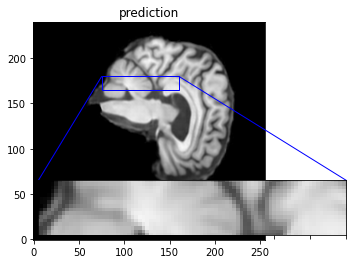

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 27.2648
PSNR of predict and high resolution is 28.8630
PSNR improvement between low resolution and prediction 1.5983


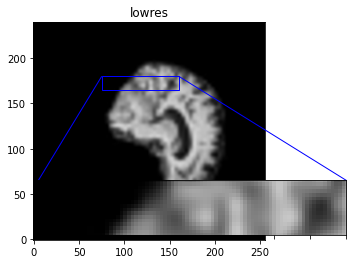

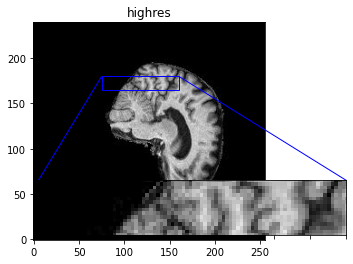

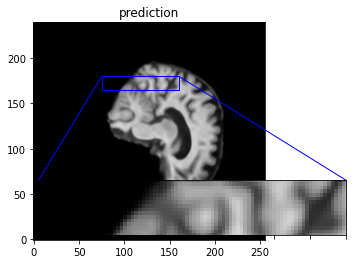

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 24.8476
PSNR of predict and high resolution is 27.0842
PSNR improvement between low resolution and prediction 2.2366


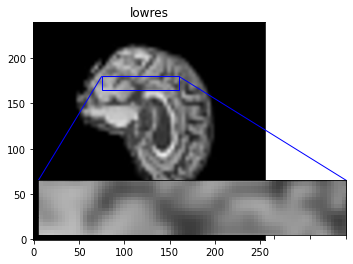

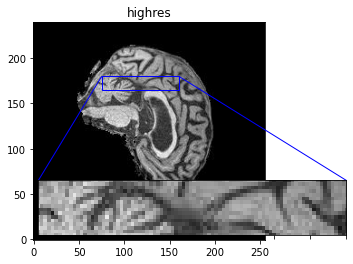

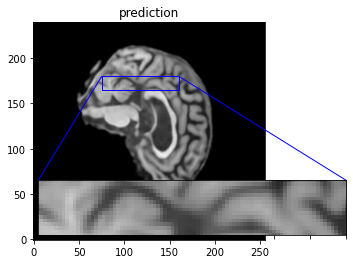

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.6749
PSNR of predict and high resolution is 27.6464
PSNR improvement between low resolution and prediction 1.9715


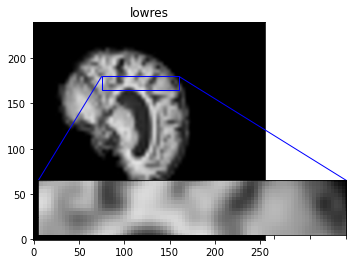

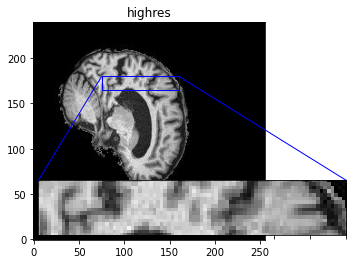

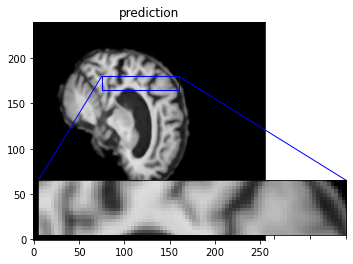

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 24.2892
PSNR of predict and high resolution is 26.1294
PSNR improvement between low resolution and prediction 1.8402


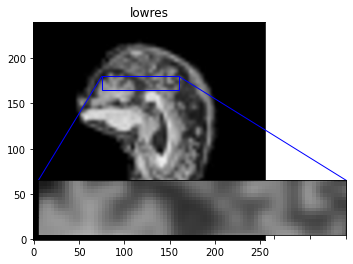

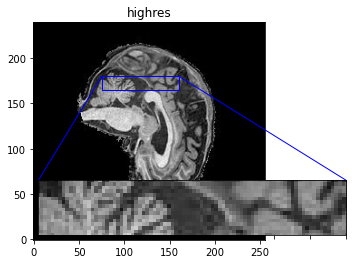

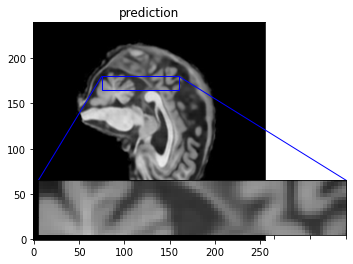

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.2594
PSNR of predict and high resolution is 27.7466
PSNR improvement between low resolution and prediction 1.4872


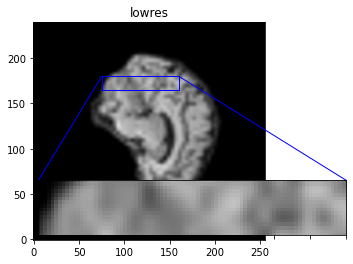

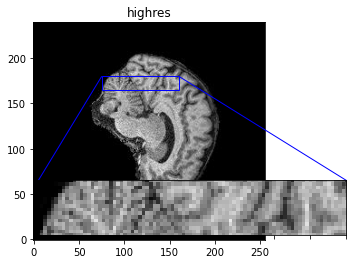

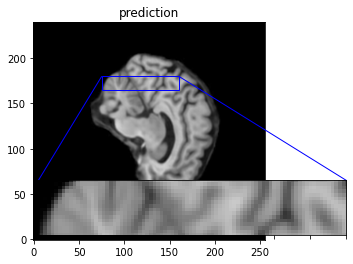

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.5161
PSNR of predict and high resolution is 27.4348
PSNR improvement between low resolution and prediction 1.9188


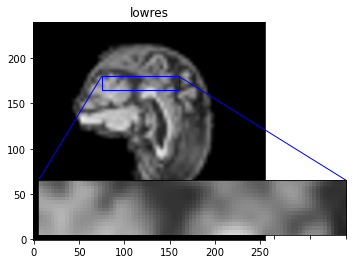

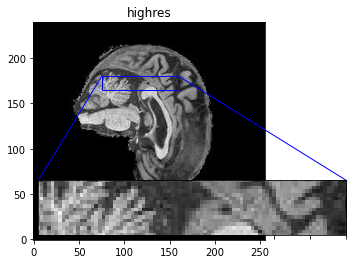

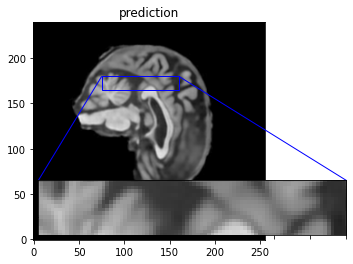

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 24.8446
PSNR of predict and high resolution is 26.9283
PSNR improvement between low resolution and prediction 2.0837


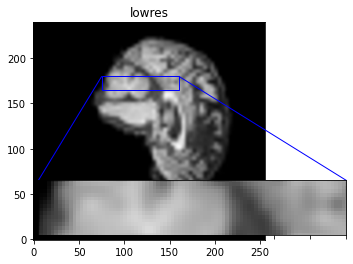

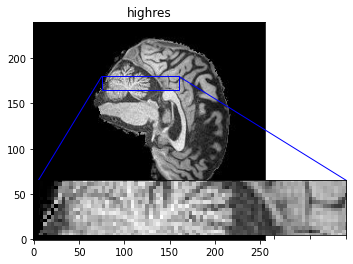

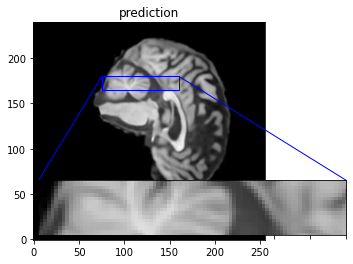

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.6556
PSNR of predict and high resolution is 27.8895
PSNR improvement between low resolution and prediction 2.2339


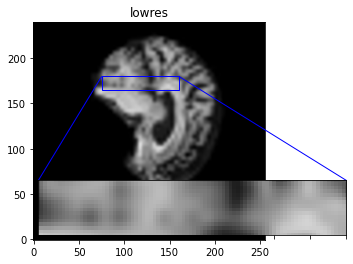

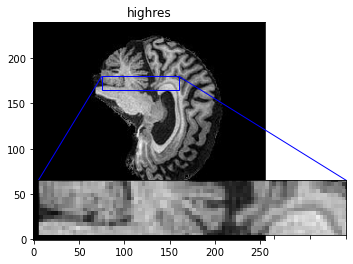

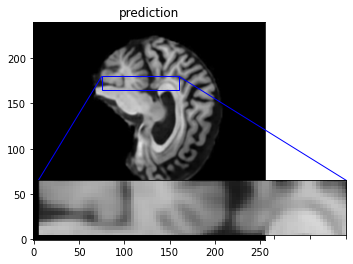

1/1 [==============================] - 0s 10ms/step
PSNR of low resolution image and high resolution image is 25.5751
PSNR of predict and high resolution is 28.3001
PSNR improvement between low resolution and prediction 2.7250


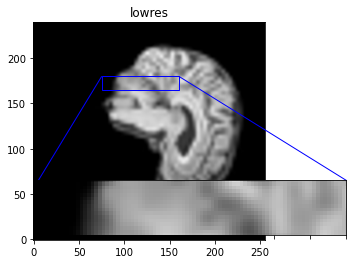

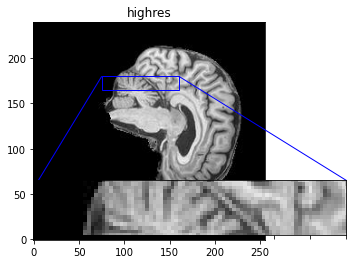

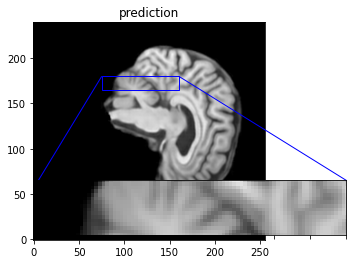

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.1142
PSNR of predict and high resolution is 28.0644
PSNR improvement between low resolution and prediction 1.9502


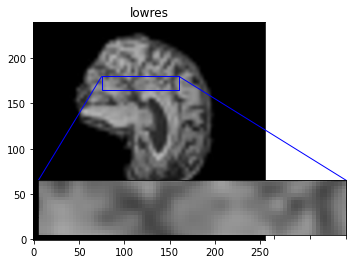

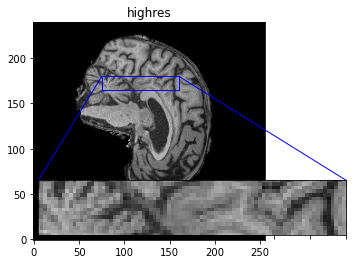

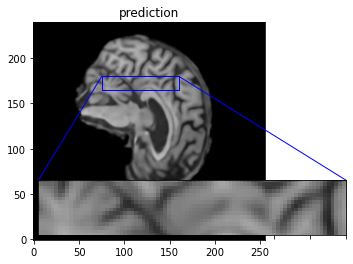

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.0621
PSNR of predict and high resolution is 27.4010
PSNR improvement between low resolution and prediction 2.3389


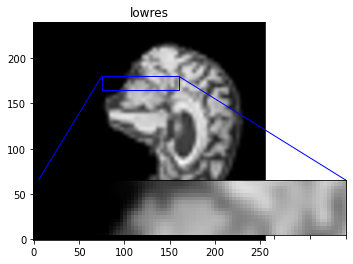

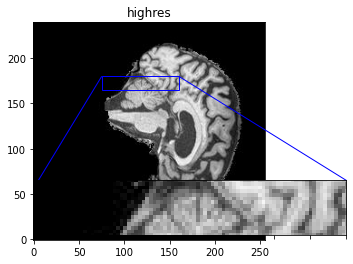

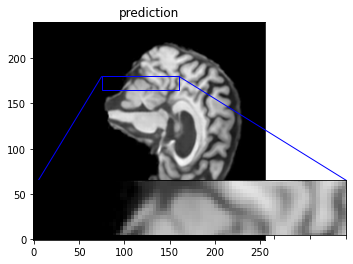

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.5239
PSNR of predict and high resolution is 26.9841
PSNR improvement between low resolution and prediction 1.4602


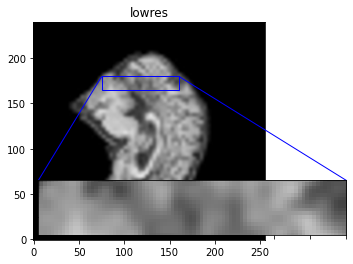

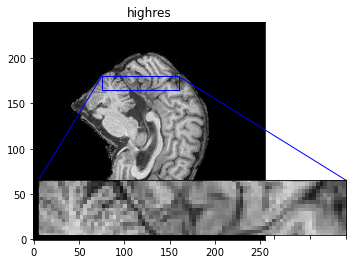

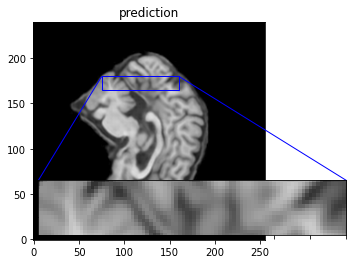

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.3736
PSNR of predict and high resolution is 28.2942
PSNR improvement between low resolution and prediction 1.9206


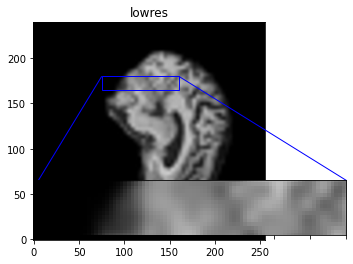

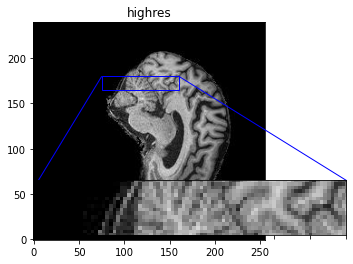

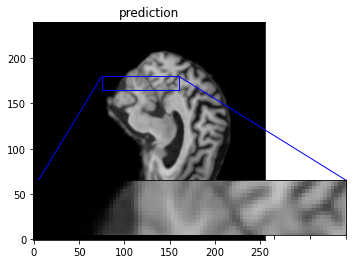

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.6149
PSNR of predict and high resolution is 28.3847
PSNR improvement between low resolution and prediction 1.7698


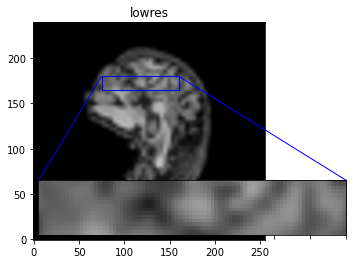

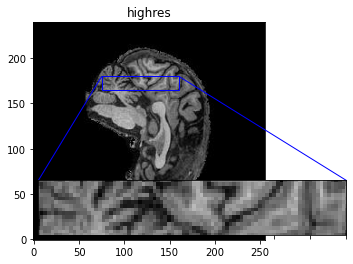

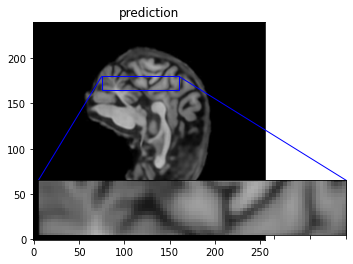

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.2881
PSNR of predict and high resolution is 27.4211
PSNR improvement between low resolution and prediction 1.1330


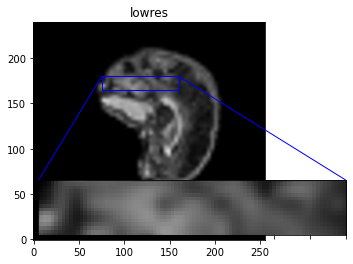

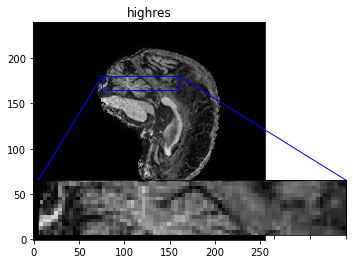

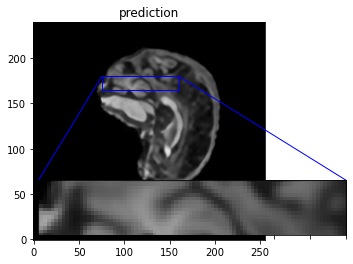

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 28.0483
PSNR of predict and high resolution is 29.8233
PSNR improvement between low resolution and prediction 1.7750


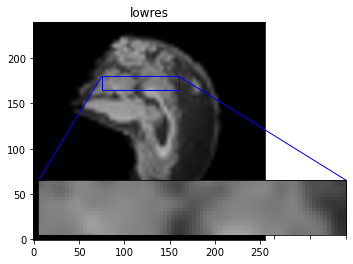

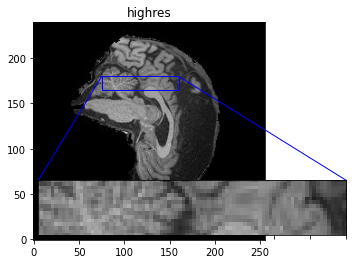

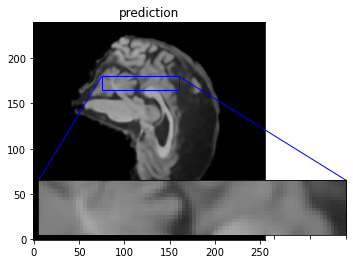

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.8367
PSNR of predict and high resolution is 26.9665
PSNR improvement between low resolution and prediction 1.1298


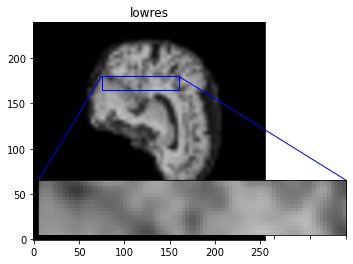

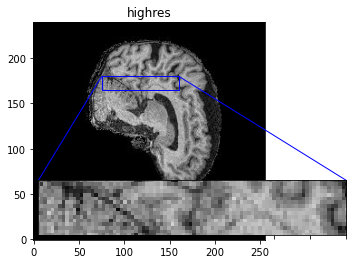

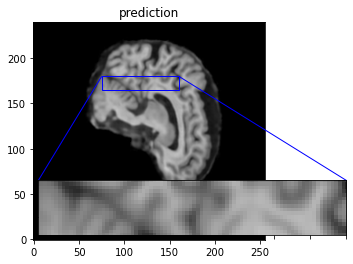

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.6446
PSNR of predict and high resolution is 28.6146
PSNR improvement between low resolution and prediction 1.9699


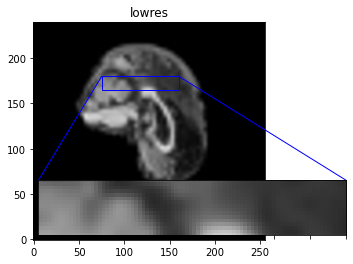

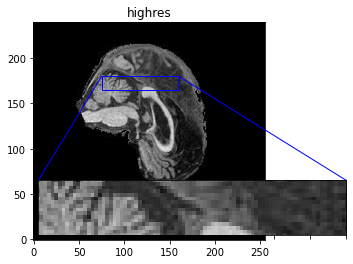

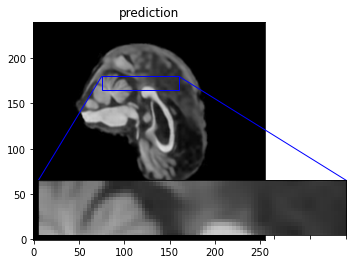

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 27.3336
PSNR of predict and high resolution is 28.7486
PSNR improvement between low resolution and prediction 1.4149


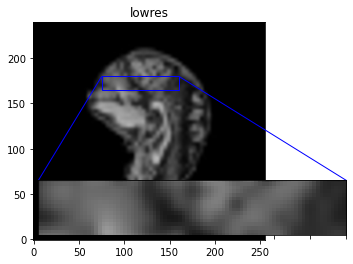

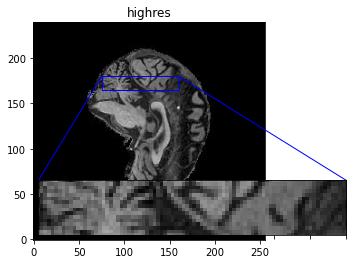

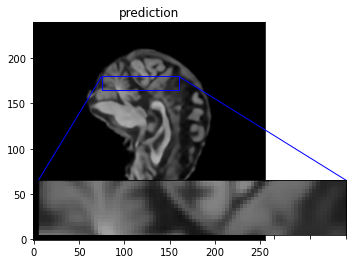

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.4702
PSNR of predict and high resolution is 27.5938
PSNR improvement between low resolution and prediction 1.1236


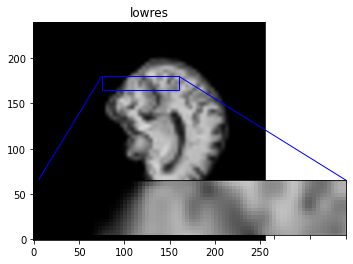

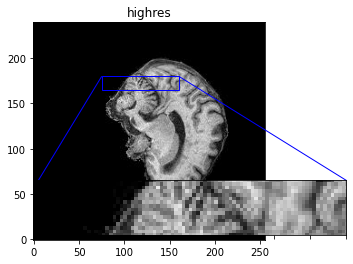

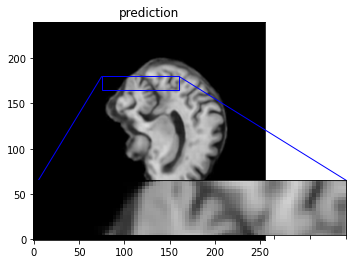

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.8532
PSNR of predict and high resolution is 28.6207
PSNR improvement between low resolution and prediction 1.7675


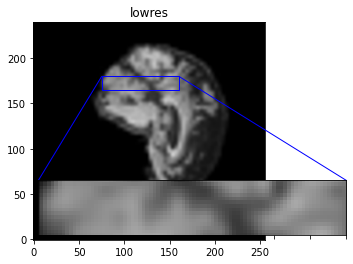

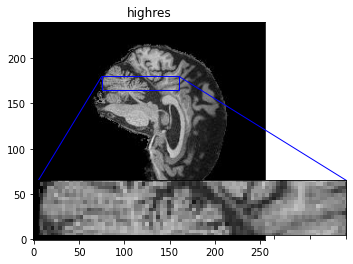

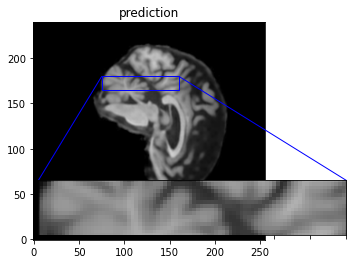

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.9266
PSNR of predict and high resolution is 27.6417
PSNR improvement between low resolution and prediction 1.7151


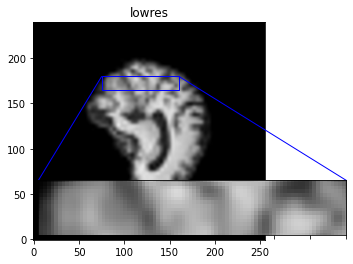

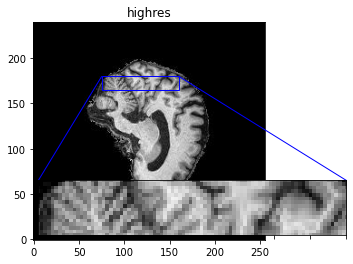

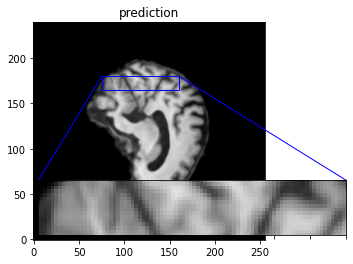

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.3770
PSNR of predict and high resolution is 26.9885
PSNR improvement between low resolution and prediction 1.6115


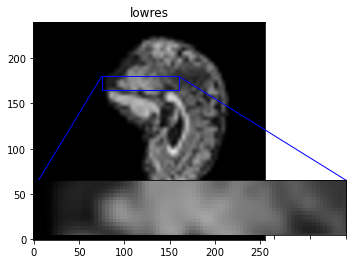

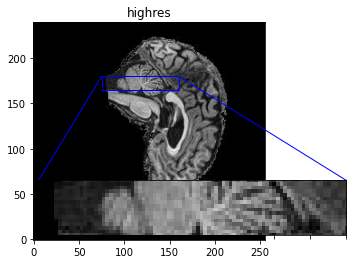

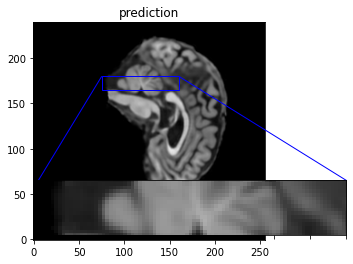

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 27.9307
PSNR of predict and high resolution is 30.5692
PSNR improvement between low resolution and prediction 2.6384


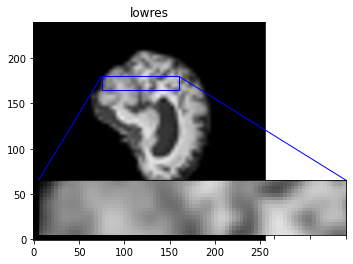

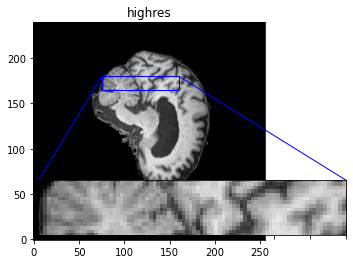

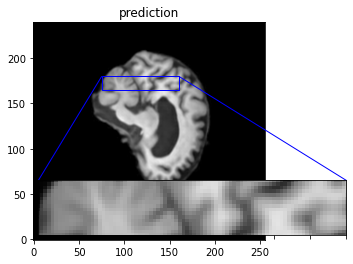

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 24.6407
PSNR of predict and high resolution is 26.3486
PSNR improvement between low resolution and prediction 1.7080


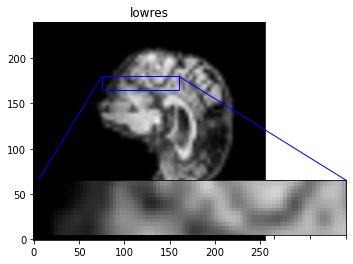

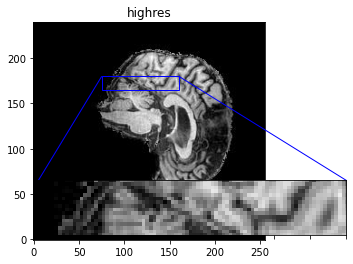

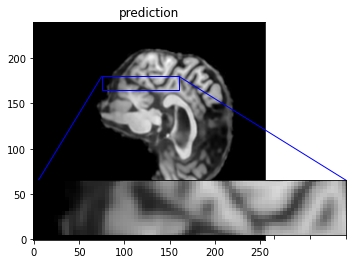

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.0729
PSNR of predict and high resolution is 27.1760
PSNR improvement between low resolution and prediction 2.1031


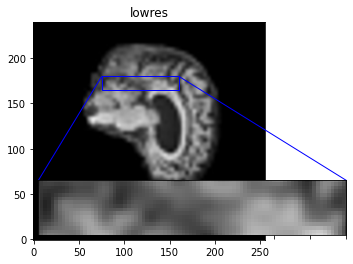

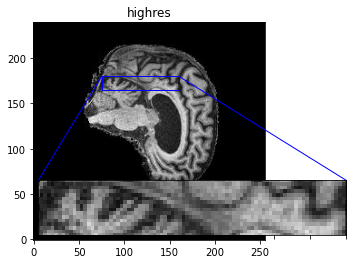

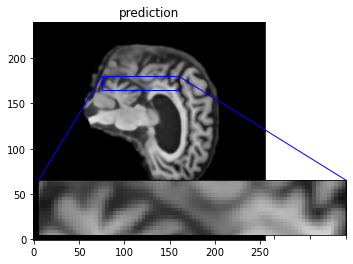

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 25.6333
PSNR of predict and high resolution is 27.8497
PSNR improvement between low resolution and prediction 2.2164


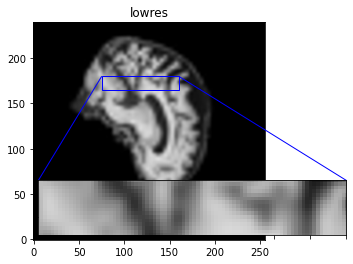

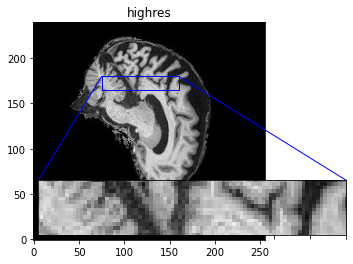

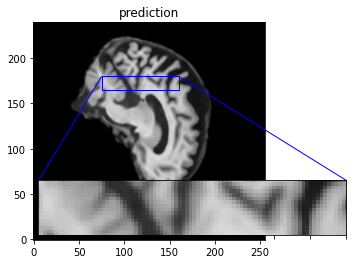

1/1 [==============================] - 0s 9ms/step
PSNR of low resolution image and high resolution image is 26.3865
PSNR of predict and high resolution is 28.5017
PSNR improvement between low resolution and prediction 2.1151


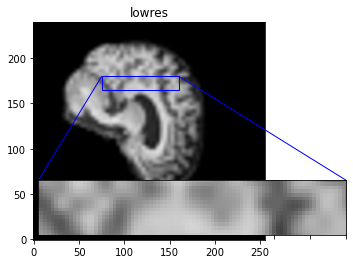

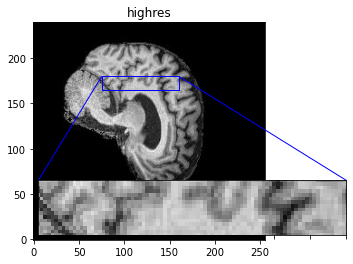

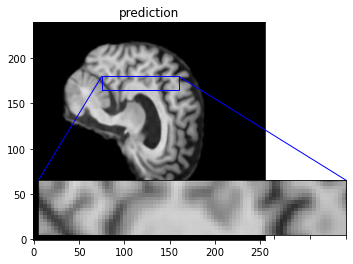

Avg. PSNR of lowres images is 25.9328
Avg. PSNR of reconstructions is 27.8162


In [4]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[0:-1:300]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    print("PSNR improvement between low resolution and prediction %.4f" % (test_psnr-bicubic_psnr))
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / len(test_img_paths[0:-1:300])))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / len(test_img_paths[0:-1:300])))